# These are the scores from twelve otherwise identical runs in which only the <span style="color:red">sequence length</span> is varied.

In [1]:
from pandas import read_csv

scores = read_csv('runs.csv', sep='\t')
scores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119 entries, 0 to 118
Data columns (total 14 columns):
job         119 non-null int64
seqlen      119 non-null int64
epochs      119 non-null int64
lrate       119 non-null float64
times       119 non-null object
f_in        119 non-null object
f_out       119 non-null object
embsize     119 non-null int64
n_heads     119 non-null int64
n_enc       119 non-null int64
n_dec       119 non-null int64
network     119 non-null object
complete    119 non-null float64
distinct    119 non-null object
dtypes: float64(2), int64(7), object(5)
memory usage: 13.1+ KB


In [2]:
scores

,job,seqlen,epochs,lrate,times,f_in,f_out,embsize,n_heads,n_enc,n_dec,network,complete,distinct
0,1192,4,14,0.000198,"(""18:47:56"", ""21:35:10"")",t-in_voc,t-out,512,8,3,3,transformer,0.718206,"[0.9414924489865595, 0.9471941185173383, 0.946..."
1,1344,4,14,0.000008,"(""17:23:41"", ""20:10:02"")",t-in_voc,t-out,512,8,3,3,transformer,0.382103,"[0.7952975452093457, 0.7879684530380453, 0.782..."
2,1345,4,14,0.000010,"(""17:23:42"", ""20:09:12"")",t-in_voc,t-out,512,8,3,3,transformer,0.430072,"[0.8177628059952884, 0.8167271734058655, 0.813..."
3,1346,4,14,0.000012,"(""17:23:47"", ""20:12:51"")",t-in_voc,t-out,512,8,3,3,transformer,0.480556,"[0.842834219121647, 0.8435284343738975, 0.8417..."
4,1347,4,14,0.000016,"(""17:30:19"", ""20:16:39"")",t-in_voc,t-out,512,8,3,3,transformer,0.539542,"[0.871069432905803, 0.8718091704696764, 0.8700..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114,2595,7,32,0.000738,"(""11:16:05"", ""17:38:16"")",t-in_voc,t-out,512,8,3,3,transformer,0.743956,"[0.9410723171818403, 0.9508627373829721, 0.951..."
115,2596,7,32,0.000740,"(""11:16:06"", ""17:29:56"")",t-in_voc,t-out,512,8,3,3,transformer,0.739524,"[0.9396373146937311, 0.9496013239055213, 0.950..."
116,2597,7,32,0.000742,"(""17:05:03"", ""23:19:52"")",t-in_voc,t-out,512,8,3,3,transformer,0.706125,"[0.9273819305412505, 0.9424726018678178, 0.943..."
117,2598,7,32,0.000746,"(""17:08:27"", ""23:29:15"")",t-in_voc,t-out,512,8,3,3,transformer,0.041152,"[0.6109407367117612, 0.42705211142099964, 0.30..."


In [3]:
# Find the combination of learning rate and number of epochs
# of which we have the most runs.
cols = ['epochs', 'lrate']
epochs, lrate = scores[cols].apply(tuple, 1).mode()[0]
print(f'Choosing number of epochs = {epochs} and learning rate = {lrate}.')

Choosing number of epochs = 30.0 and learning rate = 0.000205.


In [4]:
# Make a dataframe of the selection and sort it on learning rate.
df = scores[(scores['epochs'] == epochs) & (scores['lrate'] == lrate)].sort_values(by='seqlen')
print(f'Selection comprises {len(df)} entries.')

Selection comprises 12 entries.


# Let us first investigate the relation between the scores on the complete strings and the sequence length.

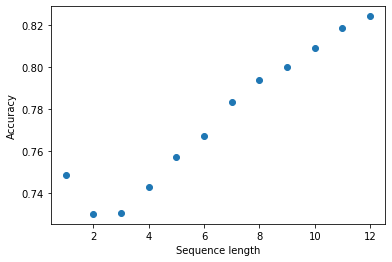

In [5]:
# Create a scatter plot of the values
from matplotlib.pyplot import plot, xlabel, ylabel

x = list(df['seqlen'])
y = list(df['complete'])

xlabel('Sequence length')
ylabel('Accuracy')
plot(x, y, 'o')

So the longer the sequence length, the better the predictions on the complete input string get. A sequence length longer than 12 causes a RuntimeError: CUDA out of memory (on a 8 GB GPU).

# Now, let us do the same for the scores on the distinct words.

In [6]:
# Turn the objects in the 'distinct' column into proper lists
# and extract the maximum value from each of them.
y = list(df['distinct'].apply(eval).apply(max))

Maximum 0.9600861001492865 for a learning rate of 7.


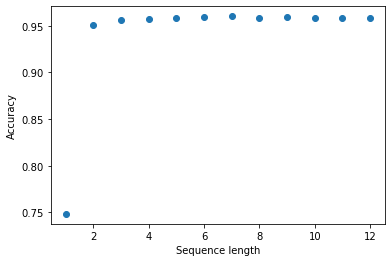

In [7]:
# Create a scatter plot of the values
xlabel('Sequence length')
ylabel('Accuracy')
plot(x, y, 'o')

from numpy import argmax
m = argmax(y)
print(f'Maximum {y[m]} for a learning rate of {x[m]}.')

Let us ignore the value for sequence length = 1 and have a look at the top values.

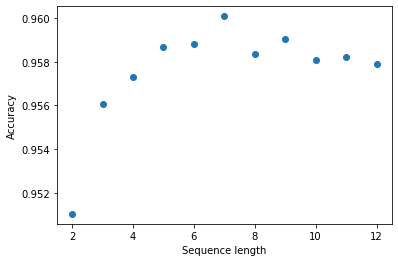

In [8]:
xlabel('Sequence length')
ylabel('Accuracy')
plot(x[1:], y[1:], 'o')

We can no longer say: "The longer the sequence length, the better the predictions." A sequence length of 7 gives the best score, but the differences are small. Which word positions were responsible for the high scores?

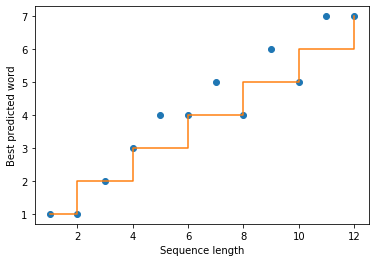

In [9]:
from matplotlib.pyplot import step

# Let us number the words from 1 on.
def argmax1(x):
    return argmax(x) + 1

best = list(df['distinct'].apply(eval).apply(argmax1))

xlabel('Sequence length')
ylabel('Best predicted word')
plot(x, best, 'o')
step(x, [n//2 + 1 for n in x], where='post')

Wtih a sequence length of 7, word 5 is most frequently predicted correctly. The orange line indicates the middle word of the sequence.

# How does the sequence length influence the running time?

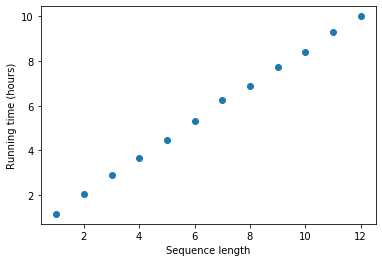

In [10]:
from datetime import datetime

def time(s):
    fmt = '%H:%M:%S'
    return datetime.strptime(s, fmt)

running_times = list(df['times'].apply(eval))
dt = []

for t in running_times:
    dt.append(time(t[1]) - time(t[0]))

y = [t.seconds/3600 for t in dt]

xlabel('Sequence length')
ylabel('Running time (hours)')
plot(x,y, 'o')

This looks like a straightforward linear relationship. So let us try to fit it to a function $f(x) = a x + b$.

In [11]:
from scipy.optimize import curve_fit

def f(n,a,b):
    return a * n + b

fit = curve_fit(f, x, y)
[a,b] = fit[0]

Running time is 0h27m plus 48m per word.


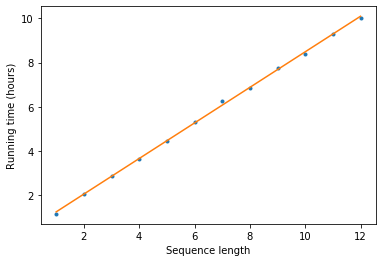

In [12]:
from numpy import vectorize

xlabel('Sequence length')
ylabel('Running time (hours)')
plot(x, y, '.')
plot(x, vectorize(f)(x,a,b))

from math import modf

m, h = modf(b)
astr = f'{int(round(60*a, 0))}m'
bstr = f'{int(h)}h{round(60*m)}m'
print(f'Running time is {bstr} plus {astr} per word.')